In [1]:
# -*- coding: utf-8 -*-
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import time
import importlib
import os
import argparse
import copy
import datetime
import random
import sys
import json

import torch
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo
from torchvision import models
import torch.multiprocessing as mp
from torchvision import transforms

# My libs
from core.utils import Stack, ToTorchFormatTensor
import xarray as xr

from ssh_scripts.plot_maps import plot
from cartopy import crs as ccrs

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
plt.rcParams ['figure.figsize']  = 25, 10
plt.rcParams ['axes.labelsize']  = 14
plt.rcParams ['xtick.labelsize'] = 12
plt.rcParams ['ytick.labelsize'] = 12
plt.rcParams ['text.color']      = 'black'
plt.rcParams ['axes.labelcolor'] = 'black'
plt.rcParams ['xtick.color']     = 'black'
plt.rcParams ['ytick.color']     = 'black'
# plt.style.use('fivethirtyeight')

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [14]:
from os import listdir
from os.path import isfile, join
mypath = 'datasets/youtube-vos/JPEGImages'
onlyfiles = [f for f in listdir(mypath)]

In [18]:
mask_path = 'ssh_examples'

In [28]:
# read frame-wise masks 
w, h = 192, 192
def read_mask(mpath):
    masks = []
    mnames = os.listdir(mpath)
    mnames.sort()
    for m in mnames: 
        if 'ipynb' not in m:
            m = Image.open(os.path.join(mpath, m))
            m = m.resize((w, h), Image.NEAREST)
            m = np.array(m.convert('L'))
            m = np.array(m > 0).astype(np.uint8)
#             m = cv2.dilate(m, cv2.getStructuringElement(
#                 cv2.MORPH_CROSS, (3, 3)), iterations=4)
            masks.append(Image.fromarray(m*255))
    return masks

def add_neighboring_masks(masks, window=1):
    window = 1
    for i in range(len_video):
        for w_ in range(-window, window+1):
            if len_video-1>=i+w_ >=0 :
                masks[i] *= masks[i+w_]
    return masks

# to drop
_to_tensors = transforms.Compose([
    Stack(),
    ToTorchFormatTensor()])


all_masks = read_mask(mask_path)
all_frames = [0]*10 # to drop

len_video = min(len(all_masks),len(all_frames))

all_frames = all_frames[:len_video]
all_masks  = all_masks[:len_video]
masks = all_masks.copy()

mask_tensors = _to_tensors(masks)

mask_tensors = add_neighboring_masks(mask_tensors, window=1)



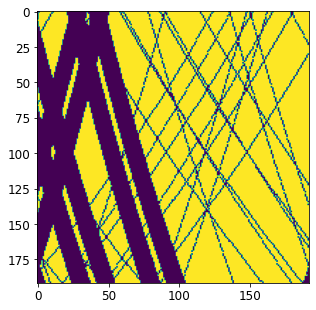

In [32]:

plt.figure(figsize=(5,5))

plt.imshow(mask_tensors[5][0].cpu())